In [6]:
dfContestacoes = sqlContext.read.parquet("hdfs:/user/x181471/cache/transacoes/credito/final/contestadas")

In [2]:
dfContestacoes.cache()

DataFrame[idSia: string, cartao: string, dataHoraAutorizacao: timestamp, idEstabelecimento: string, nomeEstabelecimento: string, ramoEstabelecimentoId: bigint, ramoEstabelecimentoNome: string, modoEntradaId: string, modoEntradaNome: string, pais: bigint, tipoLancamento: bigint, flagContestacao: boolean, valor: double, contcur: timestamp, observacoes: string]

In [3]:
dfContestacoes.count()

483122

**Verificar se existem contestações que não encontramos a autorização correspondente:**

É preciso comparar o número de transações com idSia distintos encontrados antes e depois do join com a MPDT004 (Autorizações):

In [5]:
dfContestacoes.select('idSia').distinct().count()

482308

In [6]:
dfContestacoesAntesDoJoin = sqlContext.read.parquet("hdfs:/user/x181471/cache/contestacoes/credito/final")

In [79]:
dfContestacoesAntesDoJoin.filter('flagContestacao = true').select('idSia').distinct().count()

1168451

##### Verificar os dados da MPDT343 com o modo de entrada

In [7]:
hiveContext =  pyspark.sql.HiveContext(sc)

In [8]:
#dfDetalheAutorizacoes = sqlContext.read.parquet("hdfs:/user/x181471/cache-teste/autorizacoes-MPDT343")
dfDetalheAutorizacoes = hiveContext.sql("SELECT cd_idef_sia, cd_entr_pos, nr_crto, nr_cntr_crto, dh_tran, vl_orig_tran, in_autz_cnte, in_codi_segr, in_crto_chip, dh_ulti_atlz FROM mp.MPDT343")

In [6]:
dfDetalheAutorizacoes.cache().count()

1287630406

In [9]:
dfDetalheAutorizacoes.columns

['cd_idef_sia',
 'cd_entr_pos',
 'nr_crto',
 'nr_cntr_crto',
 'dh_tran',
 'vl_orig_tran',
 'in_autz_cnte',
 'in_codi_segr',
 'in_crto_chip',
 'dh_ulti_atlz']

In [28]:
dfDetalheAutorizacoes.select([min('dataHoraAutorizacao'),max('dataHoraAutorizacao')]).toPandas()

min(dataHoraAutorizacao) max(dataHoraAutorizacao)
0                     None                     None

In [29]:
dfDetalheAutorizacoes.filter('observacoes != ""').show(5,False)

+----------------+----------------+-------------------+-------------+---------------+---------------------+-----+---------------+-------------------+--------------+---------+-----------------------------------------------------------------------------+
|idSia           |cartao          |dataHoraAutorizacao|modoEntradaId|modoEntradaNome|contcur              |valor|flagContestacao|flagCodigoSeguranca|flagCartaoChip|flagSenha|observacoes                                                                  |
+----------------+----------------+-------------------+-------------+---------------+---------------------+-----+---------------+-------------------+--------------+---------+-----------------------------------------------------------------------------+
|2025255953135470|5021212607657447|null               |51           |NÃO ENCONTRADO |2016-08-05 23:07:02.0|17.25|-2             |-2                 |1             |1        |Formato da data inválido: 160804213406;Formato da hora inválido: 16

##### Realizando os principais imports

In [2]:
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import abs, ceil, when, mean, min, max, desc, to_date, col, year, from_unixtime, unix_timestamp, dayofmonth
import pandas as pd

##### Mapeamento dos identificadores de modo de entrada feito pela área usuária

In [4]:
userEntryModes = sqlContext.createDataFrame(pd.read_csv('/home/x181471/entry_modes.csv', encoding="utf-8"))
userEntryModes.toPandas()

CodModoEntrada  AdicionaZeros  CodEntryMode  \
0                0              0             0   
1                1              1             0   
2                2              2             0   
3               10             10             1   
4               12             12             1   
5               18             18             1   
6               11             11             1   
7               19             19             1   
8               20             20             2   
9               28             28             2   
10              21             21             2   
11              22             22             2   
12              52             52             5   
13              59             59             5   
14              50             50             5   
15              58             58             5   
16              51             51             5   
17              70             70             7   
18              71             71             7   
19              72             72             7   
20             792            792            79   
21             791            791            79   
22             802            802            80   
23             808            808            80   
24             800            800            80   
25             801            801            80   
26             810            810            81   
27             811            811            81   
28             812            812            81   
29             818            818            81   
30             821            821            82   
31             890            890            89   
32             909            909            90   
33             902            902            90   
34             901            901            90   
35             900            900            90   
36             908            908            90   
37             910            910            91   
38             911            911            91   
39             912            912            91   
40             921            921            92   
41             951            951            95   

                              DescEntryMode             Grupo  
0                            Entrada manual      Não Presente  
1                            Entrada manual      Não Presente  
2                            Entrada manual      Não Presente  
3                           Manual/Digitada      Não Presente  
4                           Manual/Digitada      Não Presente  
5                           Manual/Digitada      Não Presente  
6                           Manual/Digitada      Não Presente  
7                           Manual/Digitada      Não Presente  
8                  Leitura parcial de tarja          Presente  
9                  Leitura parcial de tarja          Presente  
10                 Leitura parcial de tarja          Presente  
11                 Leitura parcial de tarja          Presente  
12                                     Chip          Presente  
13                                     Chip          Presente  
14                                     Chip          Presente  
15                                     Chip          Presente  
16                                     Chip          Presente  
17                       Contactless M/Chip          Presente  
18                       Contactless M/Chip          Presente  
19                       Contactless M/Chip          Presente  
20                           Entrada manual          Presente  
21                           Entrada manual          Presente  
22                                Fall Back          Presente  
23                                Fall Back          Presente  
24                                Fall Back          Presente  
25                                Fall Back          Presente  
26                                Ecommerce      Não Presente  
27                

##### Realizando o join entre contestações e seus detalhes

In [20]:
dfContestacoesModoEntrada = dfContestacoes.  \
  join(dfDetalheAutorizacoes, col("idSia") == col("cd_idef_sia"), 'inner'). \
  join(userEntryModes, col("cd_entr_pos") == col("CodModoEntrada")).select('idSia',
 'cartao',
 'dataHoraAutorizacao',
 'idEstabelecimento',
 'nomeEstabelecimento',
 'ramoEstabelecimentoId',
 'ramoEstabelecimentoNome',
 'modoEntradaId',
 'pais',
 'tipoLancamento',
 'flagContestacao',
 'valor',
 'contcur',
 'observacoes',
 col('DescEntryMode').alias('modoEntradaNome'),
 col('Grupo').alias('modoEntradaGrupo')).cache()

In [13]:
dfContestacoesModoEntrada.count()

315681

In [21]:
dfContestacoesModoEntrada.columns

['idSia',
 'cartao',
 'dataHoraAutorizacao',
 'idEstabelecimento',
 'nomeEstabelecimento',
 'ramoEstabelecimentoId',
 'ramoEstabelecimentoNome',
 'modoEntradaId',
 'pais',
 'tipoLancamento',
 'flagContestacao',
 'valor',
 'contcur',
 'observacoes',
 'modoEntradaNome',
 'modoEntradaGrupo']

##### Verificando a estatística básica do dado:

In [5]:
dfContestacoes.describe().show()

+-------+---------------------+------------------+-----------------+-----------------+
|summary|ramoEstabelecimentoId|              pais|   tipoLancamento|            valor|
+-------+---------------------+------------------+-----------------+-----------------+
|  count|               483122|            483122|           483122|           483122|
|   mean|     5679.11442037415|193.75455475014593|6089.014938255761|287.6288629373119|
| stddev|    1092.428475508439|263.97699414700446|39.01450611802863|1191.076364334397|
|    min|                  742|                 8|             6000|              0.0|
|    max|                 9405|               862|             6521|        306800.52|
+-------+---------------------+------------------+-----------------+-----------------+



In [6]:
dfContestacoes.show(5,False)

+----------------+----------------+---------------------+-----------------+-------------------+---------------------+-----------------------+-------------+---------------+----+--------------+---------------+------+---------------------+-----------+
|idSia           |cartao          |dataHoraAutorizacao  |idEstabelecimento|nomeEstabelecimento|ramoEstabelecimentoId|ramoEstabelecimentoNome|modoEntradaId|modoEntradaNome|pais|tipoLancamento|flagContestacao|valor |contcur              |observacoes|
+----------------+----------------+---------------------+-----------------+-------------------+---------------------+-----------------------+-------------+---------------+----+--------------+---------------+------+---------------------+-----------+
|2015043835408501|5447317322072677|2016-01-05 12:08:47.0|020541821        |CADASTRO VIVO      |5045                 |ARTIGOS ELETRÔNICOS    |01           |Digitada       |76  |6100          |true           |8.0   |2016-01-06 23:09:15.0|           |
|201

Verificando a data minima e máxima dos dados de contestação:

In [7]:
dfContestacoes.select([min('dataHoraAutorizacao'),max('dataHoraAutorizacao'),mean('valor'),min('valor'), max('valor')]).show(25,False)

+------------------------+------------------------+-----------------+----------+----------+
|min(dataHoraAutorizacao)|max(dataHoraAutorizacao)|avg(valor)       |min(valor)|max(valor)|
+------------------------+------------------------+-----------------+----------+----------+
|2011-02-13 11:56:04.0   |2016-05-11 04:17:24.0   |287.6288629373119|0.0       |306800.52 |
+------------------------+------------------------+-----------------+----------+----------+



In [8]:
dfContestacoes.show

<bound method DataFrame.show of DataFrame[idSia: string, cartao: string, dataHoraAutorizacao: timestamp, idEstabelecimento: string, nomeEstabelecimento: string, ramoEstabelecimentoId: bigint, ramoEstabelecimentoNome: string, modoEntradaId: string, modoEntradaNome: string, pais: bigint, tipoLancamento: bigint, flagContestacao: boolean, valor: double, contcur: timestamp, observacoes: string]>

## Avaliando a distribuição de contestações pelo modo entrada e país

Preperando os dados para os gráficos com novas colunas

In [7]:
#dfContestacoesModoEntrada = dfContestacoes.withColumn('usoPresente',
#                                                      when(dfContestacoes.modoEntradaNome == "Tarja","Presente").
#                                                      when(dfContestacoes.modoEntradaNome == "Chip","Presente").
#                                                      otherwise("Não Presente"))

Analisando o ramo do estabelecimento vs o tipo de uso (Presente x Não Presente):

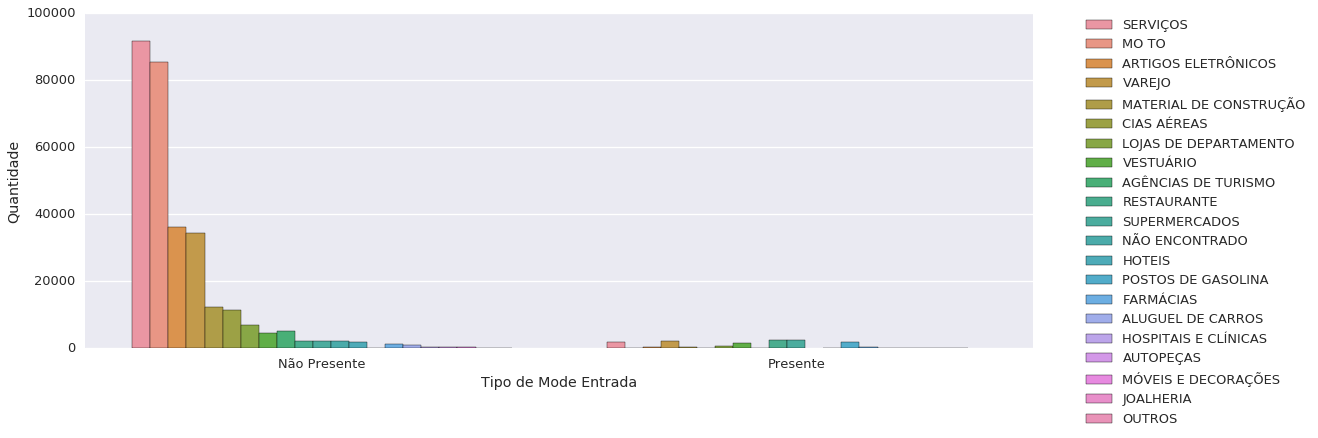

In [23]:
from pyspark.sql.functions import desc
sns.set_context("talk")
plt.figure(figsize=(17, 6))

contestacoesPorRamoEUsoPandas = dfContestacoesModoEntrada.cube("ramoEstabelecimentoNome", "modoEntradaGrupo").count(). \
  orderBy("modoEntradaGrupo",desc("count")).toPandas()
g = sns.barplot(x="modoEntradaGrupo", y="count", hue="ramoEstabelecimentoNome", data=contestacoesPorRamoEUsoPandas)
g.set(xlabel='Tipo de Mode Entrada', ylabel='Quantidade')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

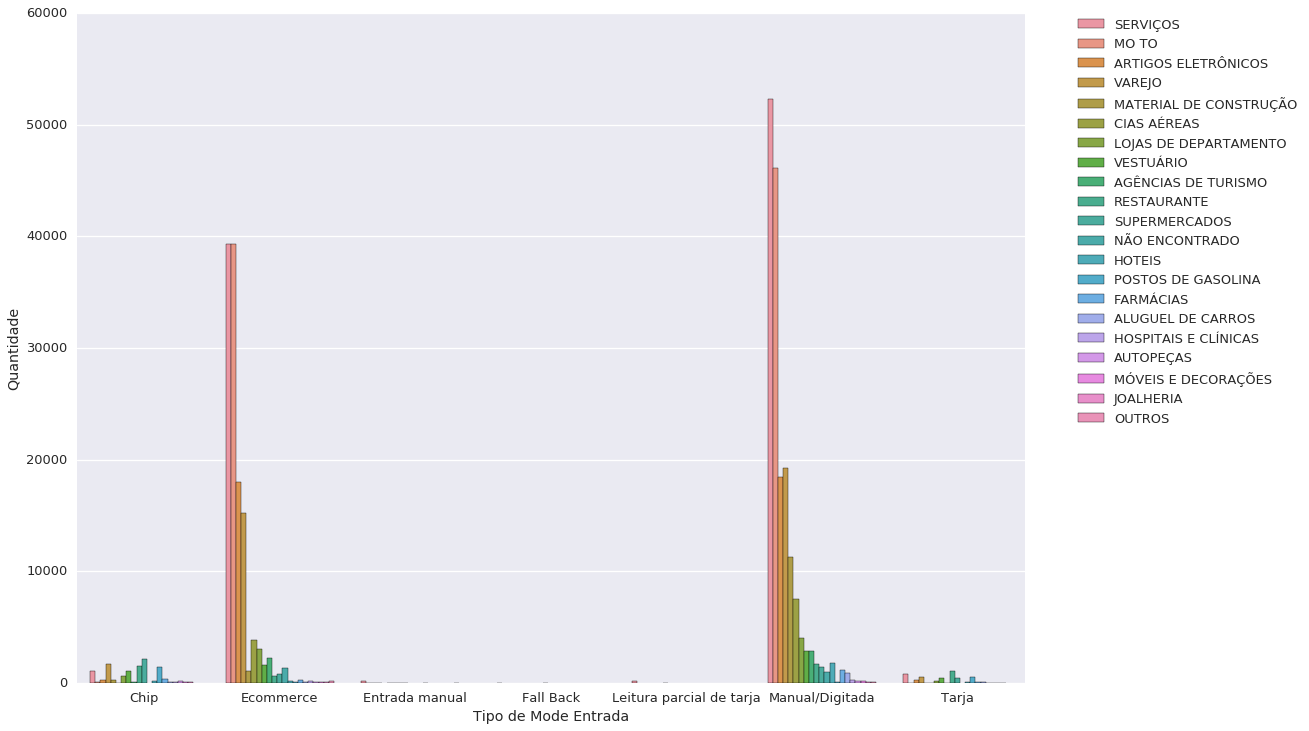

In [24]:
sns.set_context("talk")
plt.figure(figsize=(17, 12))
contestacoesPorRamoEModoEntradaPandas = dfContestacoesModoEntrada.cube("ramoEstabelecimentoNome","modoEntradaNome").count(). \
  orderBy("modoEntradaNome",desc("count")).toPandas()
g = sns.barplot(x="modoEntradaNome", y="count", hue="ramoEstabelecimentoNome", data=contestacoesPorRamoEModoEntradaPandas)
g.set(xlabel='Tipo de Mode Entrada', ylabel='Quantidade')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Quais são os países que temos mais problemas com o uso presente (Tarja/Chip)?

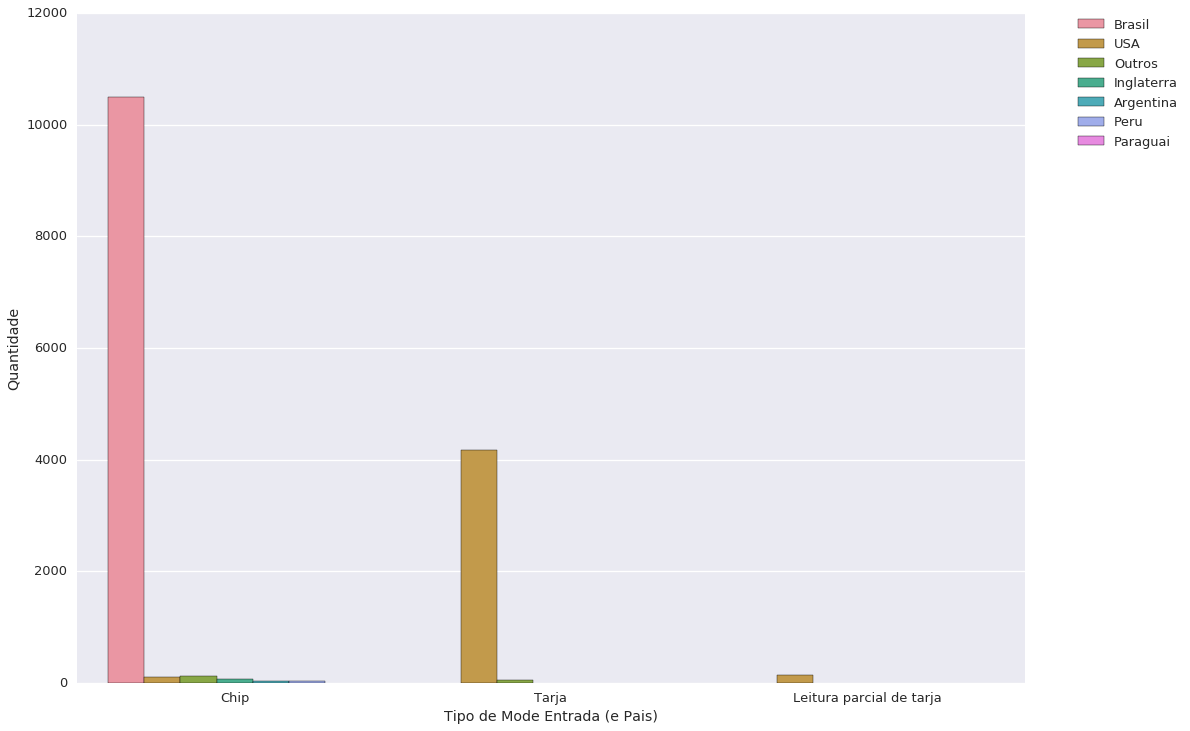

In [25]:
from pyspark.sql.functions import desc
dfContestacoesPorPaisEUso = dfContestacoesModoEntrada.filter("modoEntradaGrupo = 'Presente'").withColumn('pais',
                                                      when(dfContestacoes.pais == 32,"Argentina").
                                                      when(dfContestacoes.pais == 76,"Brasil").
                                                      when(dfContestacoes.pais == 250,"França").
                                                      when(dfContestacoes.pais == 600,"Paraguai").
                                                      when(dfContestacoes.pais == 604,"Peru").
                                                      when(dfContestacoes.pais == 840,"USA").
                                                      when(dfContestacoes.pais == 826,"Inglaterra").
                                                      otherwise("Outros"))
dfContestacoesPorPaisEUsoPandas = dfContestacoesPorPaisEUso.cube("pais", "modoEntradaNome").count().orderBy(desc("count")).toPandas().head(20)
sns.set_context("talk")
plt.figure(figsize=(17, 12))
g = sns.barplot(x="modoEntradaNome", y="count", hue="pais", data=dfContestacoesPorPaisEUsoPandas)
g.set(xlabel='Tipo de Mode Entrada (e Pais)', ylabel='Quantidade')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Avaliando tendencias de contestações ao longo do tempo

Vamos avaliar a quantidade de contestações ao longo do tempo para identificar tendencias. Vamos considerar a quantidade ao invés do valor pois:
* Valores mudam ao longo do tempo conforme a tendencia inflacionária
* Valores mudam variam ao longo do tempo por conta da oscilação da moeda

Quantidade de contestações ao longo do tempo:

Preparando a data para manipulação:

Contestações ao longo do tempo:

In [26]:
dfContestacoesDataFull = dfContestacoesModoEntrada.withColumn('dataAutorizacao',to_date(dfContestacoesModoEntrada.dataHoraAutorizacao))
#dfCountContestacoesDatapandas = dfContestacoesData.toPandas()

In [29]:
dfContestacoesDataFull.limit(5).toPandas()

idSia            cartao dataHoraAutorizacao idEstabelecimento  \
0  1014922909982316  4220612163644485 2015-09-06 12:26:14   232416900159901   
1  1015134129643004  4108639647216926 2016-04-05 00:40:38   000323033815990   
2  2015027815737750  5155900298502645 2015-12-20 17:58:37   222220032610001   
3  2015055850986530  5543890656410112 2016-01-17 09:08:28   67326100013P003   
4  1014993983834817  4916753913705363 2015-11-16 11:32:49   232416900159901   

  nomeEstabelecimento  ramoEstabelecimentoId ramoEstabelecimentoNome  \
0      DUNKIN .334776                   5814             RESTAURANTE   
1     1053 PBC  HAYWA                   5814             RESTAURANTE   
2     APPLE STORE  .R                   5732     ARTIGOS ELETRÔNICOS   
3     MTA VENDING MAC                   4111                SERVIÇOS   
4      DUNKIN .334776                   5814             RESTAURANTE   

  modoEntradaId  pais  tipoLancamento flagContestacao    valor  \
0            02   840            6102            True   104.54   
1            02   840            6102            True     5.38   
2            90   840            6102            True  7222.02   
3            02   840            6102            True   470.98   
4            02   840            6102            True    93.50   

              contcur observacoes modoEntradaNome modoEntradaGrupo  \
0 2015-09-08 22:59:34                       Tarja         Presente   
1 2016-04-06 22:46:18                       Tarja         Presente   
2 2015-12-22 23:32:24                       Tarja         Presente   
3 2016-01-19 22:50:28                       Tarja         Presente   
4 2015-11-18 23:10:39                       Tarja         Presente   

  dataAutorizacao  
0      2015-09-06  
1      2016-04-05  
2      2015-12-20  
3      2016-01-17  
4      2015-11-16

In [30]:
dfCountContestacoesPorDiaFullPandas = dfContestacoesDataFull.groupBy('dataAutorizacao').count().select(col('dataAutorizacao'),
                                                                                                       col('count').alias('qtde')).toPandas()

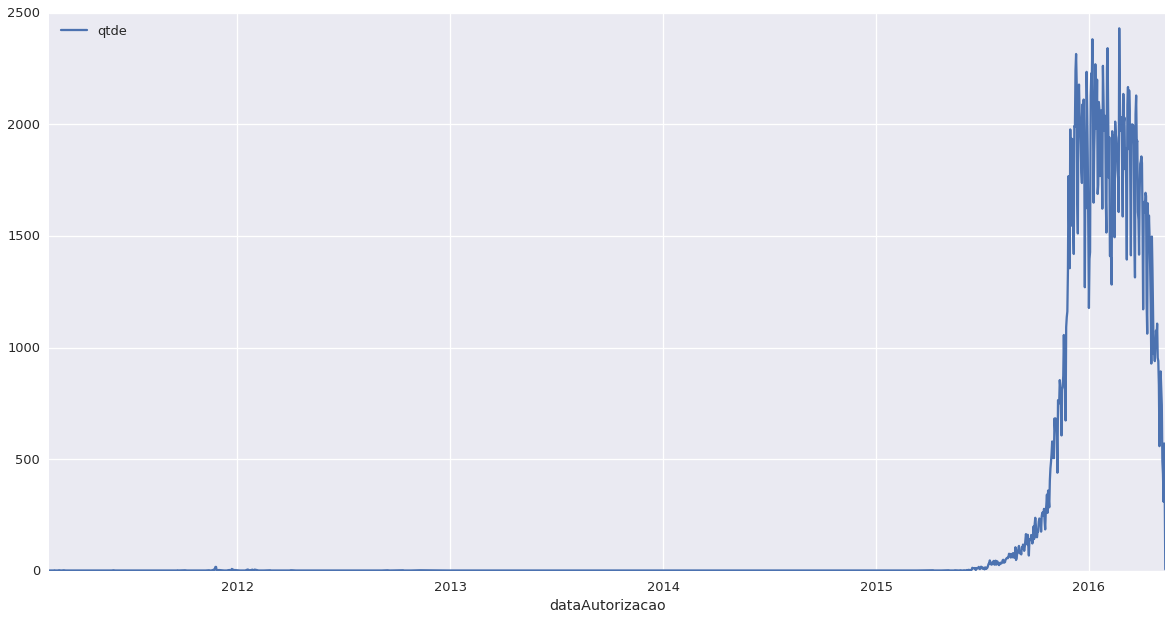

In [31]:
dfCountContestacoesPorDiaFullPandas.sort_values(by='dataAutorizacao').set_index('dataAutorizacao').plot(figsize=(20,10))

# Plota com o std
#sns.plot(data=dfCountContestacoesPorDiaPandas)

Aparentemente, somente temos registros importantes de constestações a entre **outubro-2015 e março de-2016 (6 meses).**:

Realiza as seguintes operações para análise de variâncias:
* Adiciona a informação do dia da semana
* Adiciona a informação da semana do mês

In [35]:
#dfContestacoesData = dfContestacoesDataFull.withColumn('ano',year('dataAutorizacao')).filter('ano > 2014').cache()
dfContestacoesData = dfContestacoesDataFull.filter(
    col("dataAutorizacao").between("2015-12-01","2016-04-01")).withColumn("DiaDaSemana",
    from_unixtime(unix_timestamp(col("dataAutorizacao"),"yyyy-MM-dd"),"EEEEE")).withColumn("SemanaDoMes",
    ceil(dayofmonth(col("dataAutorizacao")) / 7)).cache()
dfCountContestacoesPorDiaPandas = dfContestacoesData.groupBy('dataAutorizacao','DiaDaSemana','SemanaDoMes').count().select(col('dataAutorizacao'),
                                    col('DiaDaSemana'),col('SemanaDoMes'),col('count').alias('qtde')).toPandas()

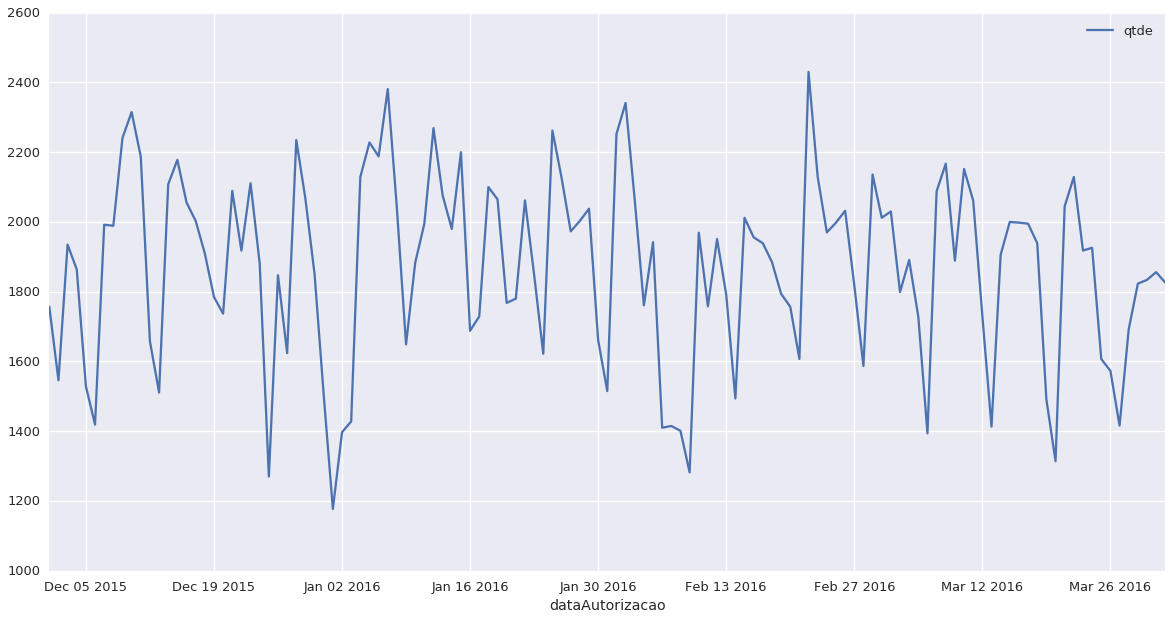

In [36]:
dfCountContestacoesPorDiaPandas[["dataAutorizacao","qtde"]].sort_values(by='dataAutorizacao').set_index('dataAutorizacao').plot(figsize=(20,10))

**Verificando a variância por dia da semana:**

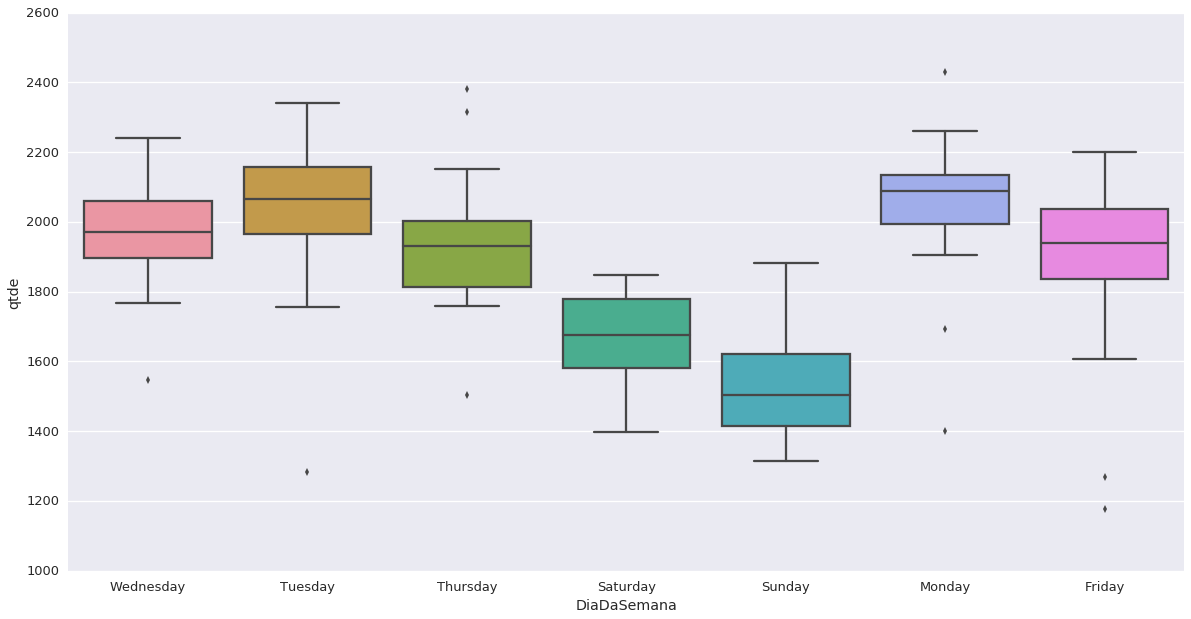

In [37]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.boxplot(x="DiaDaSemana", y="qtde", data=dfCountContestacoesPorDiaPandas)

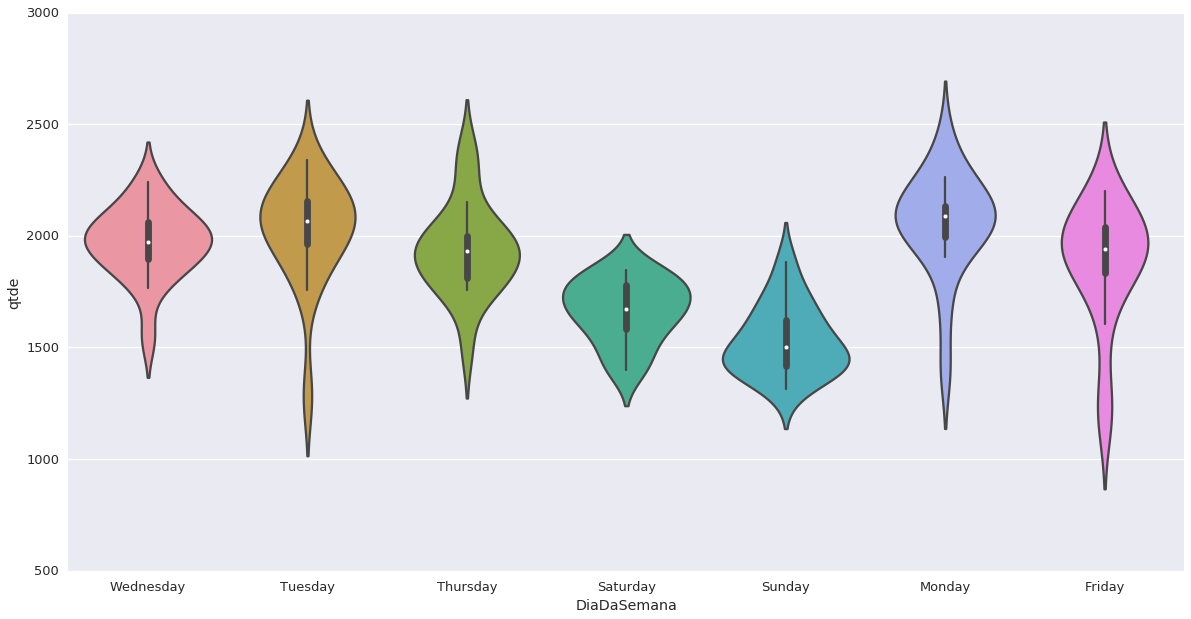

In [38]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.violinplot(x="DiaDaSemana", y="qtde", data=dfCountContestacoesPorDiaPandas)

**Verificando a variância por semana do mês:**

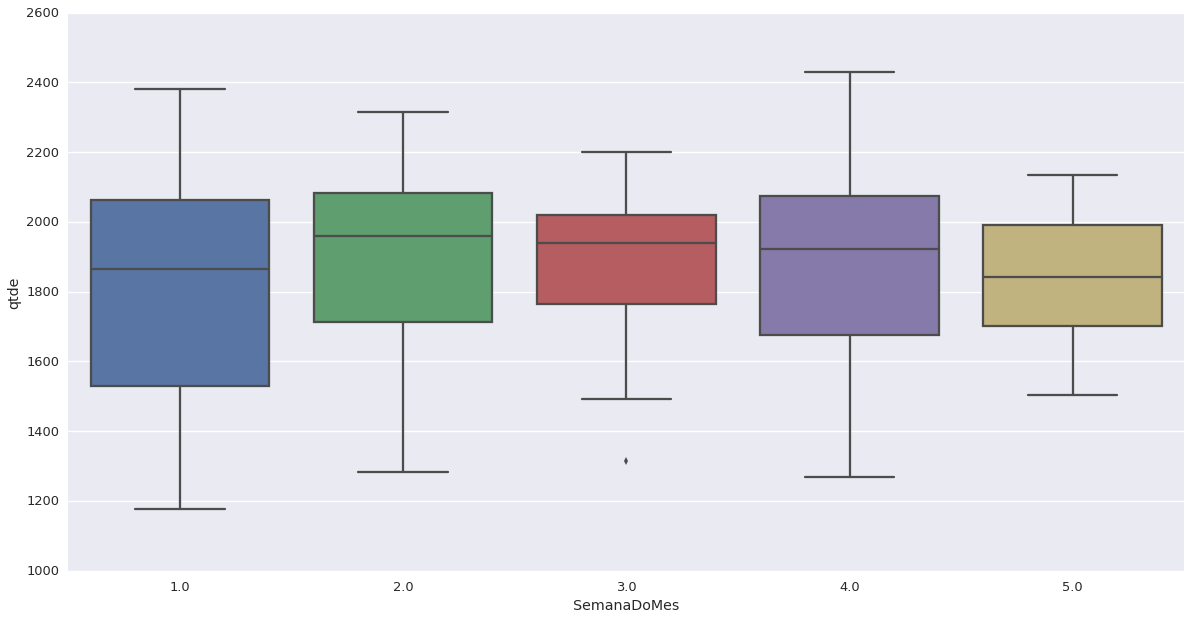

In [39]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.boxplot(x="SemanaDoMes", y="qtde", data=dfCountContestacoesPorDiaPandas)

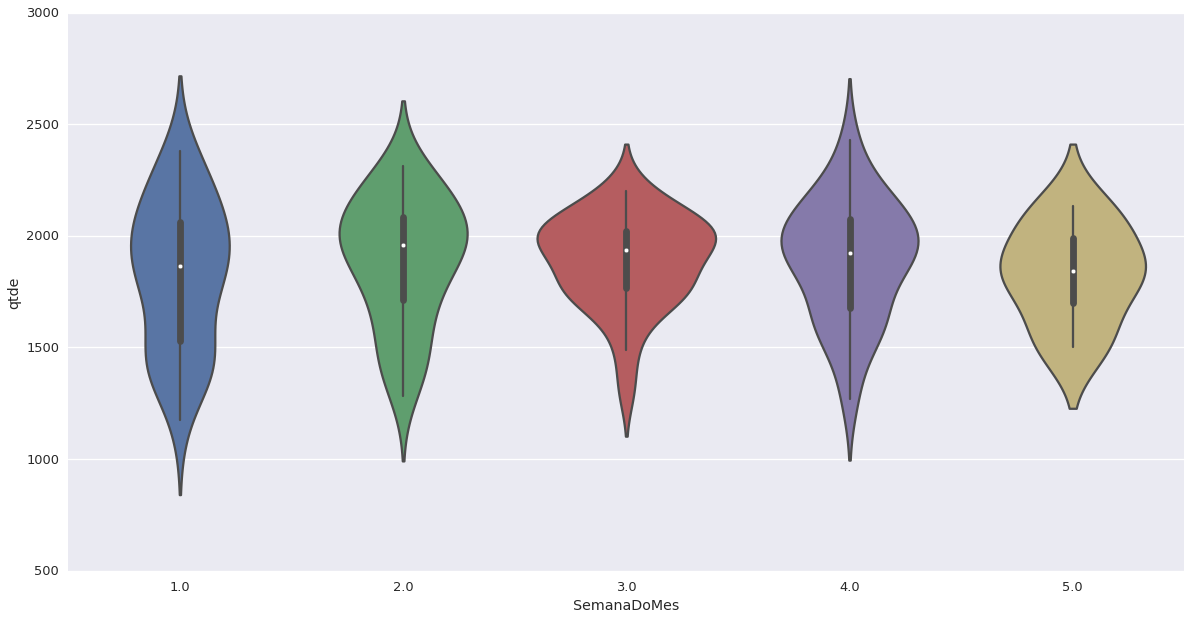

In [40]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.violinplot(x="SemanaDoMes", y="qtde", data=dfCountContestacoesPorDiaPandas)

### Incluindo o modo de entrada na análise das variâncias

**Verificando a variância por dia da semana e modo de entrada Não Presente:**

In [48]:
dfCountContestacoesPorDiaEModoEntradaPandas = dfContestacoesData.groupBy('dataAutorizacao',
    'DiaDaSemana','SemanaDoMes','modoEntradaNome','modoEntradaGrupo').count(). \
    select(col('dataAutorizacao'),col('DiaDaSemana'),col('SemanaDoMes'),col('modoEntradaNome'),
           col('modoEntradaGrupo'),col('count').alias('qtde')).cache()

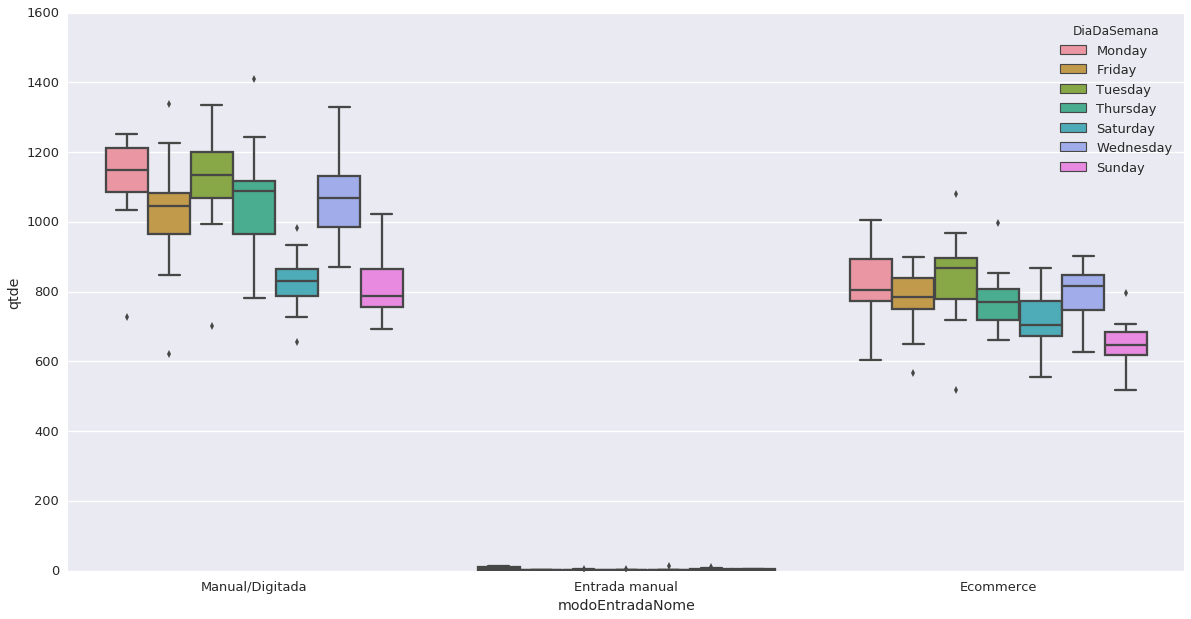

In [49]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.boxplot(x="modoEntradaNome",hue="DiaDaSemana", y="qtde", 
                 data=dfCountContestacoesPorDiaEModoEntradaPandas.filter('modoEntradaGrupo = "Não Presente"').toPandas())

**Verificando a variância por semana do mês e modo de entrada digitado:**

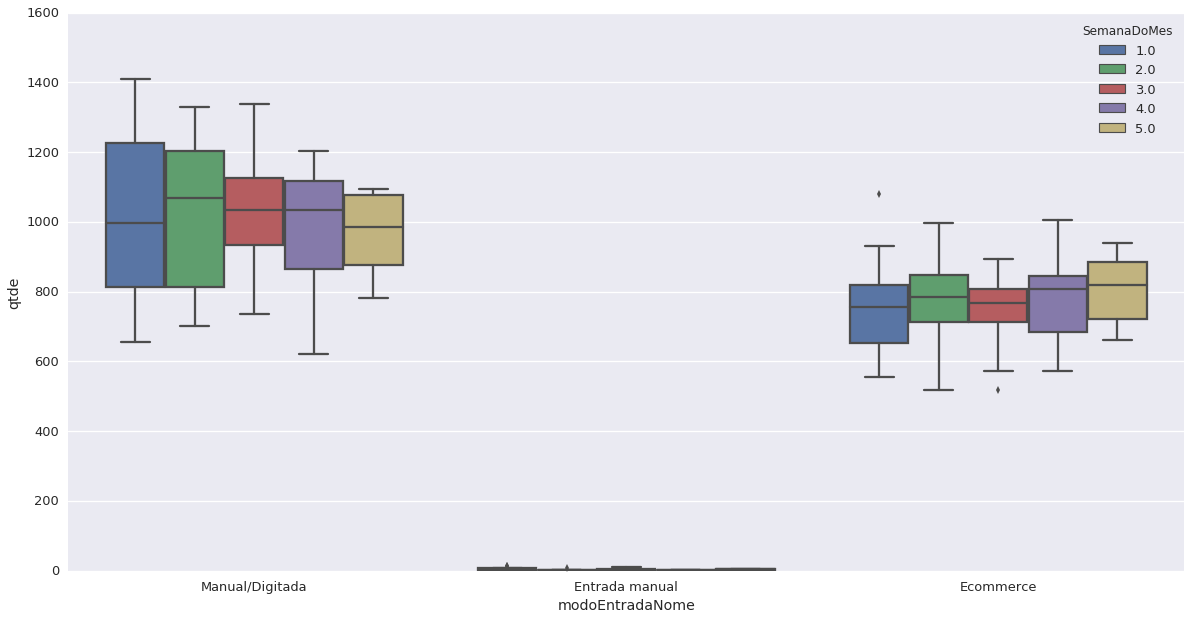

In [50]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.boxplot(x="modoEntradaNome",hue="SemanaDoMes", y="qtde", 
                 data=dfCountContestacoesPorDiaEModoEntradaPandas.filter('modoEntradaGrupo = "Não Presente"').toPandas())

**Verificando a variância por dia da semana e modo de entrada presente:**

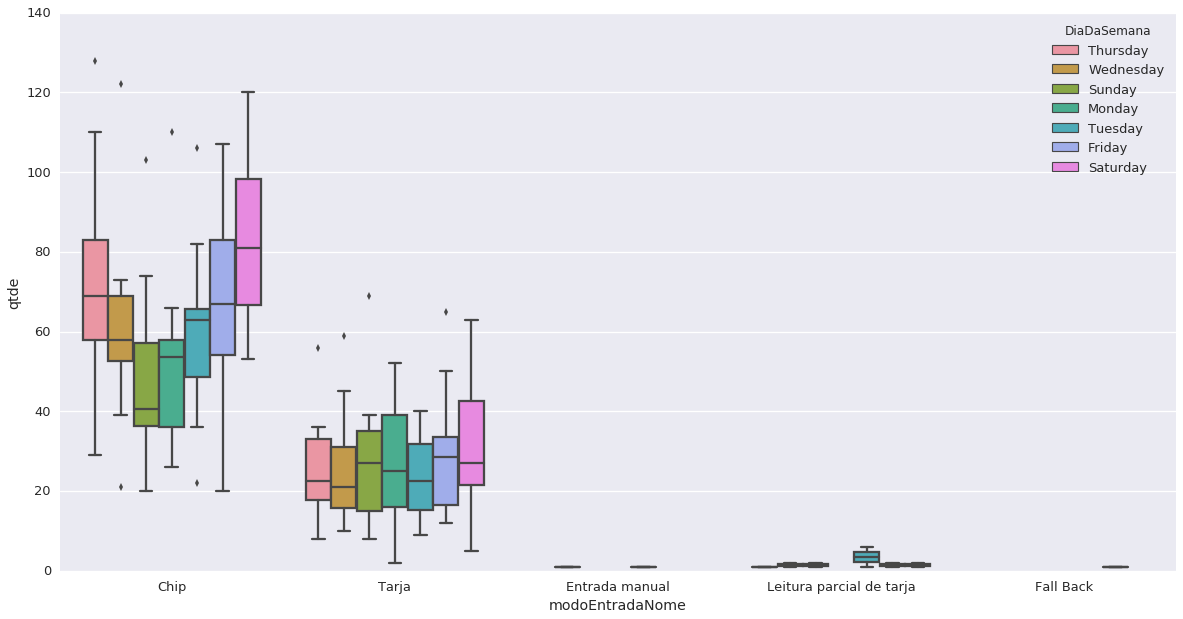

In [52]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.boxplot(x="modoEntradaNome",hue="DiaDaSemana", y="qtde", 
  data=dfCountContestacoesPorDiaEModoEntradaPandas.filter('modoEntradaGrupo = "Presente"').toPandas())

**Verificando a variância por semana do mês e modo de entrada presente:**

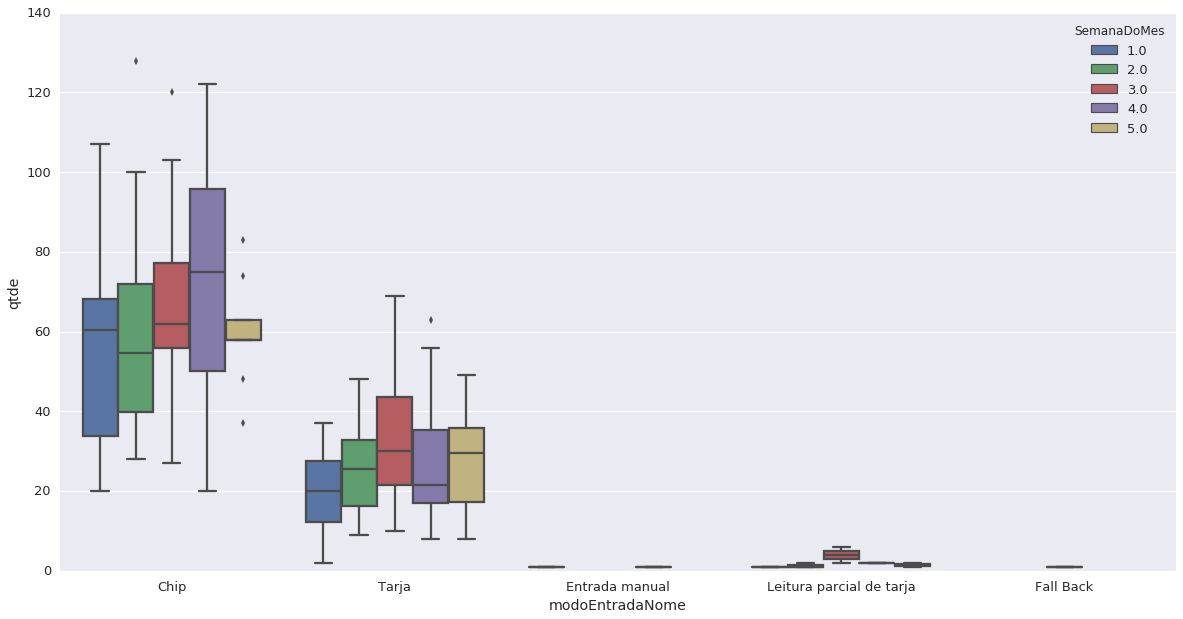

In [54]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.boxplot(x="modoEntradaNome",hue="SemanaDoMes", y="qtde", 
  data=dfCountContestacoesPorDiaEModoEntradaPandas.filter('modoEntradaGrupo = "Presente"').toPandas())

Quantidade de contestações ao longo do tempo por **modo de entrada:**

In [77]:
pandasDFPorModoEntradaEDia = dfContestacoesData.groupBy('dataAutorizacao','modoEntradaNome','modoEntradaGrupo').count(). \
  select(col('dataAutorizacao'),col('modoEntradaNome'),col('count').alias('qtde'),col('modoEntradaGrupo')).toPandas()
#pd.DataFrame(dfCountContestacoesDatapandas[['dataAutorizacao','modoEntradaNome']].groupby(['dataAutorizacao','modoEntradaNome']).size())

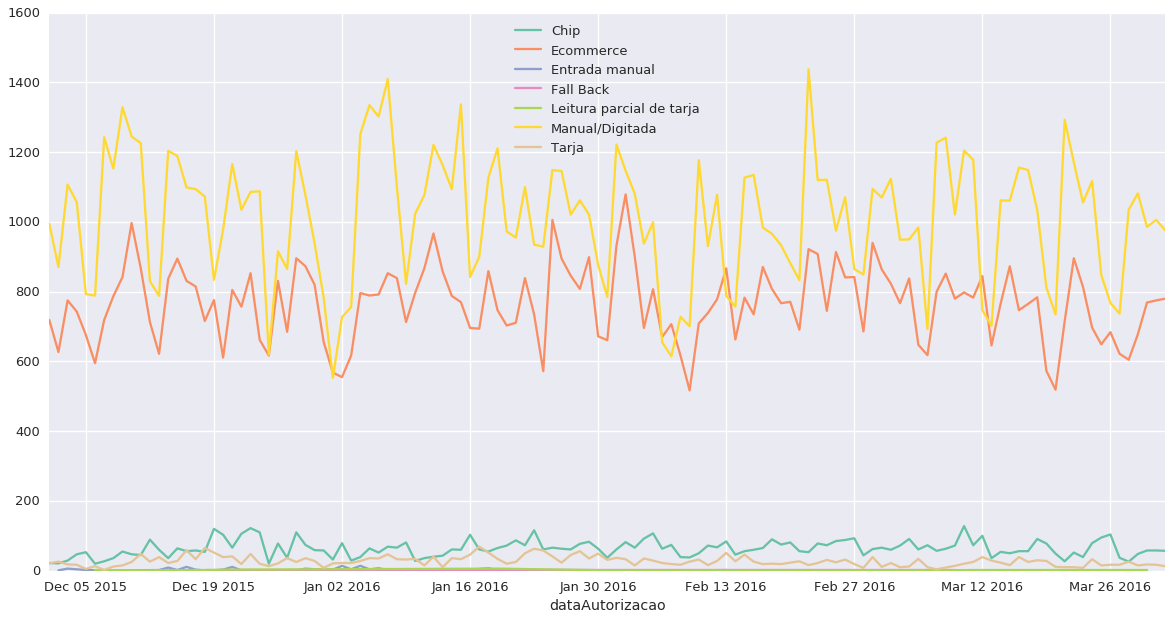

In [78]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_color_cycle(sns.color_palette("Set2",10))
labels = []
for key, grp in pandasDFPorModoEntradaEDia.groupby(['modoEntradaNome']):
    ax = grp.plot(ax=ax, kind='line', x='dataAutorizacao', y='qtde')
    labels.append(key)
lines, _ = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')
plt.show()

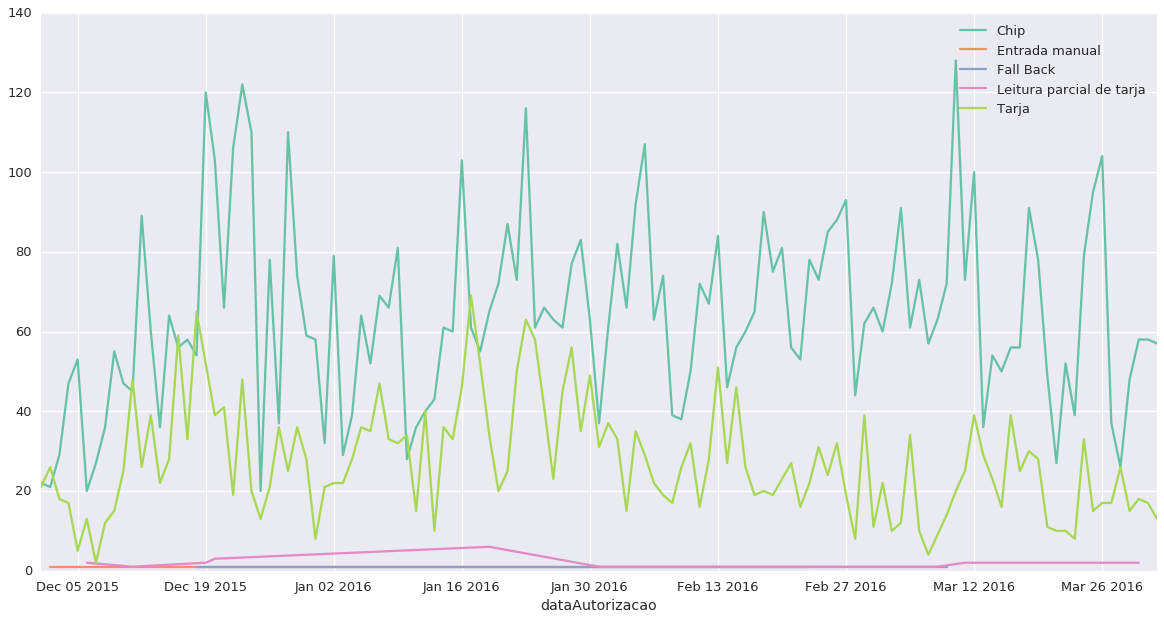

In [80]:
pandasDFPorModoEntradaEDiaSemDigitada = pandasDFPorModoEntradaEDia[pandasDFPorModoEntradaEDia['modoEntradaGrupo'] != u'Não Presente']
fig, ax = plt.subplots(figsize=(20,10))
ax.set_color_cycle(sns.color_palette("Set2",10))
labels = []
for key, grp in pandasDFPorModoEntradaEDiaSemDigitada.groupby(['modoEntradaNome']):
    ax = grp.plot(ax=ax, kind='line', x='dataAutorizacao', y='qtde')
    labels.append(key)
lines, _ = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')
plt.show()

Quantidade de contestações ao longo do tempo por **modo de entrada - STACKED**:

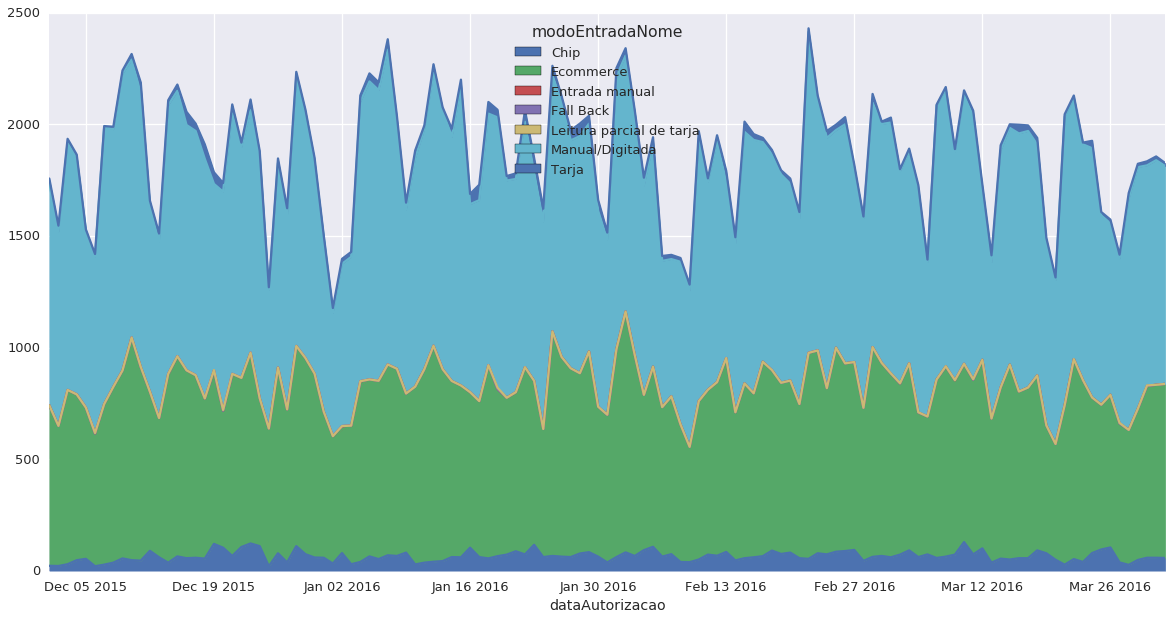

In [75]:
ax = pandasDFPorModoEntradaEDia.groupby(['dataAutorizacao','modoEntradaNome']).qtde.sum().unstack('modoEntradaNome').fillna(0). \
  plot.area(figsize=(20,10)).set_color_cycle(sns.color_palette("Set2",10))
    
#pandasContestDiaModoEntrada.set_index('dataAutorizacao').plot()

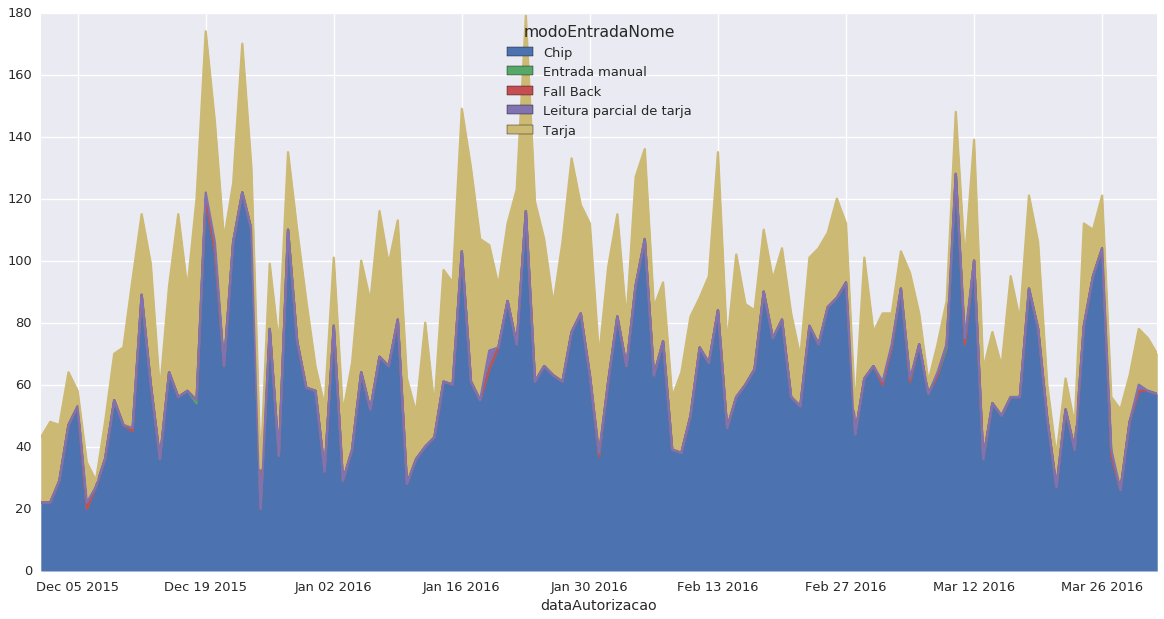

In [81]:
pandasDFPorModoEntradaEDia[pandasDFPorModoEntradaEDia['modoEntradaGrupo'] != u'Não Presente']. \
  groupby(['dataAutorizacao','modoEntradaNome']).qtde.sum().unstack('modoEntradaNome').fillna(0). \
    plot.area(figsize=(20,10))

Quantidade de contestações ao longo do tempo por **modo de entrada - Presente Não Presente:**

Quantidade de contestações ao longo do tempo por **modo de entrada - Presente Não Presente - STACKED**:

Quantidade de contestações ao longo do tempo por **ramo de estabelecimento:**

In [82]:
pandasDFPorRamoEstabelecimentoEDia = dfContestacoesData.groupBy('dataAutorizacao',
  'ramoEstabelecimentoNome').count().select(col('dataAutorizacao'),
  col('ramoEstabelecimentoNome'),
  col('count').alias('qtde')).filter('(ramoEstabelecimentoNome = "SERVIÇOS") or (ramoEstabelecimentoNome = "MO TO") or (ramoEstabelecimentoNome = "ARTIGOS ELETRÔNICOS") or (ramoEstabelecimentoNome = "VAREJO")').toPandas()

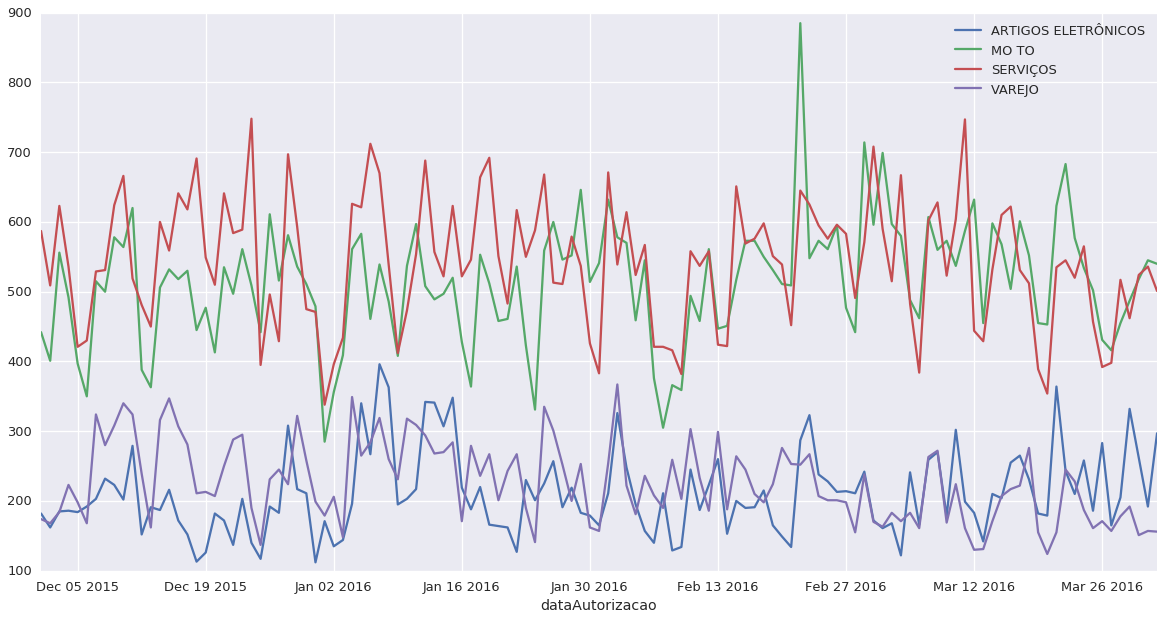

In [83]:
fig, ax = plt.subplots(figsize=(20,10))
#ax.set_color_cycle(sns.color_palette("Set2",21))
labels = []
for key, grp in pandasDFPorRamoEstabelecimentoEDia.groupby(['ramoEstabelecimentoNome']):
    ax = grp.plot(ax=ax, kind='line', x='dataAutorizacao', y='qtde')
    labels.append(key)
lines, _ = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')
plt.show()

Quantidade de contestações ao longo do tempo por **ramo de estabelecimento - STACKED:**

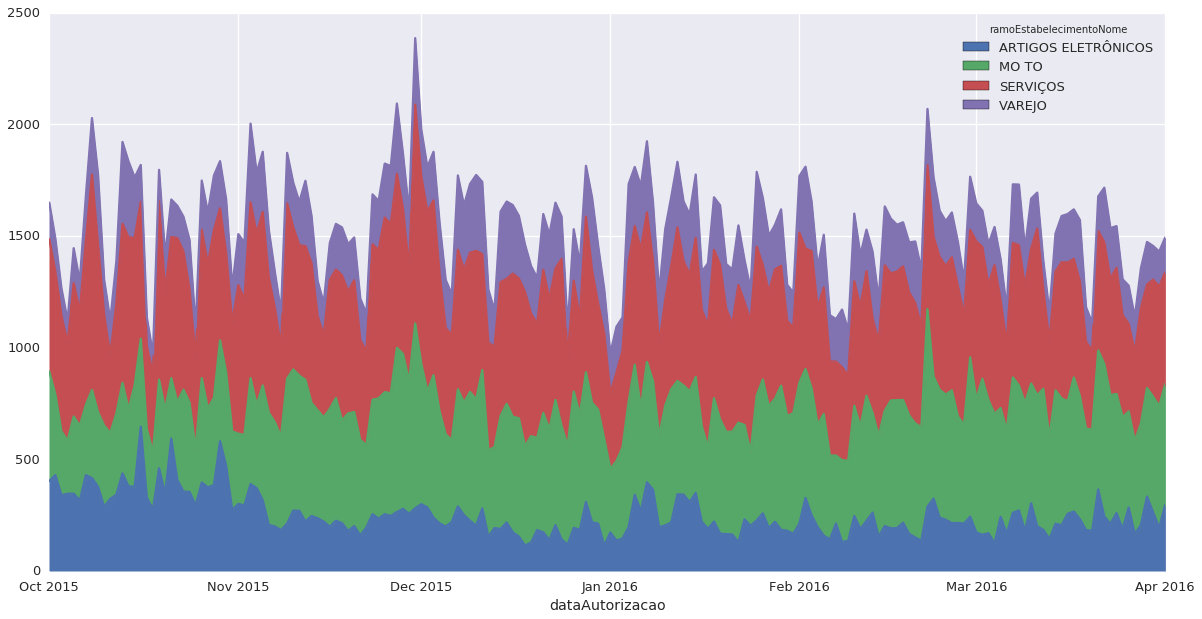

In [105]:
pandasDFPorRamoEstabelecimentoEDia.groupby(['dataAutorizacao',
                                            'ramoEstabelecimentoNome']).qtde.sum().unstack('ramoEstabelecimentoNome').fillna(0).plot.area(figsize=(20,10))


Quantidade de contestações ao longo do tempo por **país:**

In [106]:
dfContestacoesComPais = dfContestacoesData.withColumn('pais',
                                                      when(dfContestacoes.pais == 32,"Argentina").
                                                      when(dfContestacoes.pais == 76,"Brasil").
                                                      when(dfContestacoes.pais == 250,"França").
                                                      when(dfContestacoes.pais == 600,"Paraguai").
                                                      when(dfContestacoes.pais == 604,"Peru").
                                                      when(dfContestacoes.pais == 840,"USA").
                                                      when(dfContestacoes.pais == 826,"Inglaterra").
                                                      otherwise("Outros"))
dfContestacoesPorPais = dfContestacoesComPais.groupBy('dataAutorizacao','pais').count().select(col('dataAutorizacao'),
                                                                    col('pais'),col('count').alias('qtde')).toPandas()

# Sem utilização ainda
dfContestacoesComPaisEPorUsoPresente = dfContestacoesComPais.filter("usoPresente = 'Presente'")

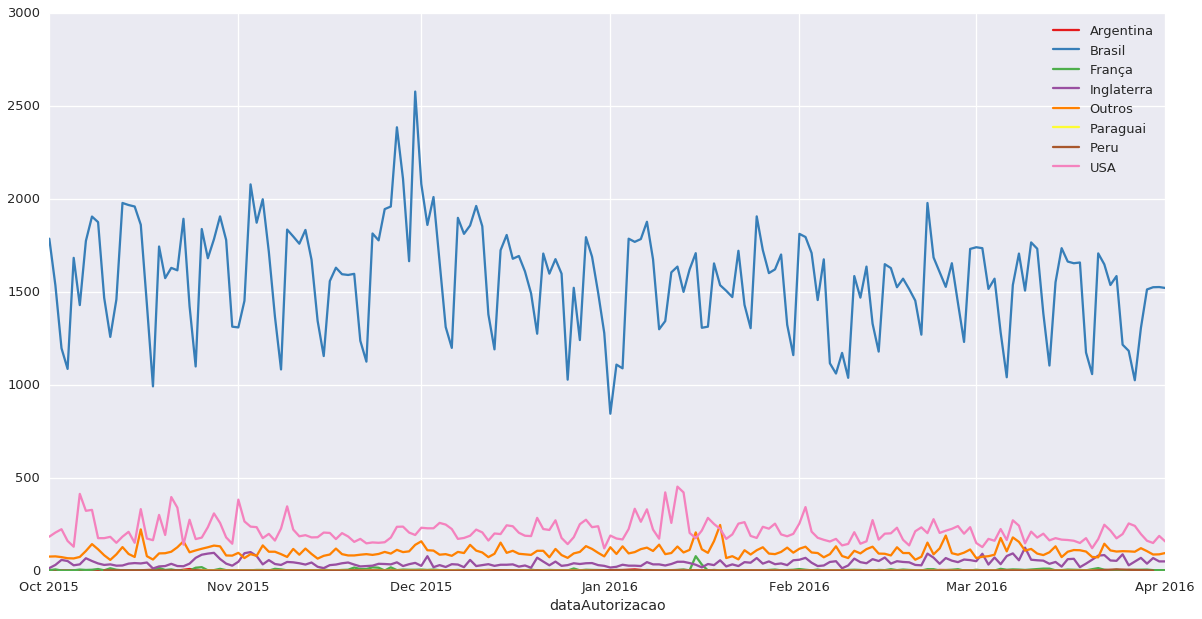

In [107]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_color_cycle(sns.color_palette("Set1",21))
labels = []
for key, grp in dfContestacoesPorPais.groupby(['pais']):
    ax = grp.plot(ax=ax, kind='line', x='dataAutorizacao', y='qtde')
    labels.append(key)
lines, _ = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')
plt.show()

Quantidade de contestações ao longo do tempo por **país - STACKED:**

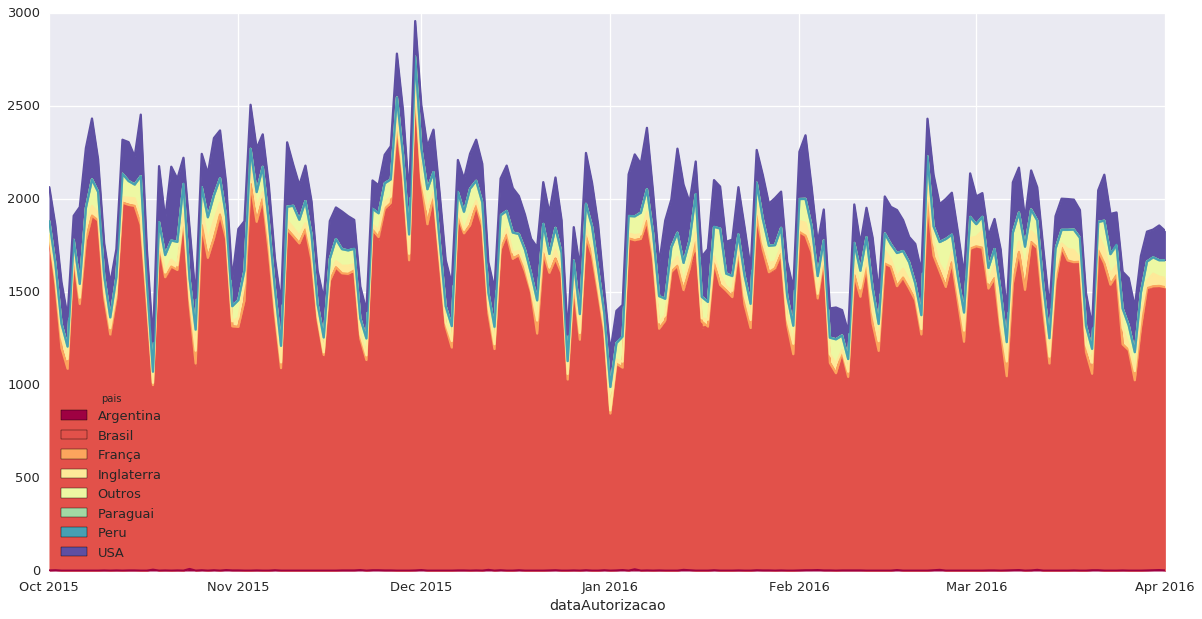

In [108]:
import matplotlib.pyplot as plt
sns.color_palette("Set1",21)
dfContestacoesPorPais.groupby(['dataAutorizacao','pais']).qtde.sum().unstack('pais').fillna(0). \
  plot.area(figsize=(20,10),colormap='Spectral')